<a href="https://colab.research.google.com/github/eduardodarocha/Criando-um-sistema-de-reconhecimento-facial-do-zero-/blob/main/Criando_um_sistema_de_reconhecimento_facial_do_zero_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow pandas

In [3]:
from google.colab import files
import zipfile
import os

# Upload folder (you'll need to zip the folder first)
uploaded = files.upload()


Saving dataset.zip to dataset.zip


In [4]:
import zipfile
import os

# Step 1: Define the name of the uploaded ZIP file
zip_filename = 'dataset.zip'  # Name of the uploaded ZIP file

# Step 2: Create a folder to unzip the contents into (optional)
extract_folder = '/content/unzipped_folder'  # You can change this path
os.makedirs(extract_folder, exist_ok=True)

# Step 3: Unzip the file
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"Contents extracted to {extract_folder}.")

# Step 4: List the files in the extracted folder (optional)
extracted_files = os.listdir(extract_folder)
print("Extracted files:", extracted_files)


Contents extracted to /content/unzipped_folder.
Extracted files: ['dataset', '__MACOSX']


In [5]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical

# Define function to load and preprocess images
def load_and_preprocess_images(image_paths, target_size=(224, 224)):
    images = []
    for img_path in image_paths:
        img = image.load_img(img_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        images.append(img_array)
    return np.vstack(images)  # Stack images into a single numpy array

# Define paths
dataset_dir = '/content/unzipped_folder/dataset'  # Path to your dataset

# Get the list of class folders (e.g., class_1, class_2, ...)
# Ensure we only consider directories, exclude hidden folders like __MACOSX, and exclude 'train' and 'validation'
classes = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d)) and not d.startswith('.') and d not in ['train', 'validation']])


# Manually split images per class: 70% for training, 30% for testing
train_images = []
test_images = []
train_labels = []
test_labels = []

# Iterate through each class folder
for class_idx, class_name in enumerate(classes):
    class_folder = os.path.join(dataset_dir, class_name)

    # Get all image paths in the class folder
    image_paths = [os.path.join(class_folder, img) for img in os.listdir(class_folder) if img.lower().endswith(('.jpg', '.png', '.jpeg'))]

    # Add a check to skip if the class folder is empty or contains no valid images
    if not image_paths:
        print(f"Skipping class '{class_name}': No valid image files found.")
        continue

    # Split into 70% for training and 30% for testing
    class_train, class_test = train_test_split(image_paths, test_size=0.3, random_state=42)

    # Add the split image paths to the lists
    train_images.extend(class_train)
    test_images.extend(class_test)
    train_labels.extend([class_idx] * len(class_train))
    test_labels.extend([class_idx] * len(class_test))

# Load and preprocess the images from the training and testing paths
# Add a check to ensure train_images and test_images are not empty before processing
if not train_images or not test_images:
    print("Error: Not enough images found across all classes to create non-empty training and testing sets.")
else:
    X_train = load_and_preprocess_images(train_images)
    X_test = load_and_preprocess_images(test_images)

    # One-hot encode the labels (0-based class indices)
    y_train = to_categorical(train_labels, num_classes=len(classes))
    y_test = to_categorical(test_labels, num_classes=len(classes))

    # Verify the shapes of X_train, X_test, y_train, and y_test
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")

X_train shape: (490, 224, 224, 3)
X_test shape: (210, 224, 224, 3)
y_train shape: (490, 6)
y_test shape: (210, 6)


In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load VGG16 model with weights from ImageNet, without the top classification layer
base_model = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

# Unfreeze the last 4 layers of VGG16 for fine-tuning
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Build the custom model
model = Sequential([
    base_model,  # VGG16 as the feature extractor
    Flatten(),   # Flatten the output from VGG16 to pass to dense layers
    Dense(64, activation='relu'),
    BatchNormalization(),  # Normalize activations to stabilize training
    Dropout(0.5),  # Dropout for regularization to prevent overfitting
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dense(6, activation='softmax')  # Output layer for 6 classes (classification task)
])

# Compile the model with a smaller learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary to verify the architecture
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,323,542 (62.27 MB)

 Trainable params: 8,688,054 (33.14 MB)

 Non-trainable params: 7,635,488 (29.13 MB)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=5 ,validation_data=(X_test, y_test))

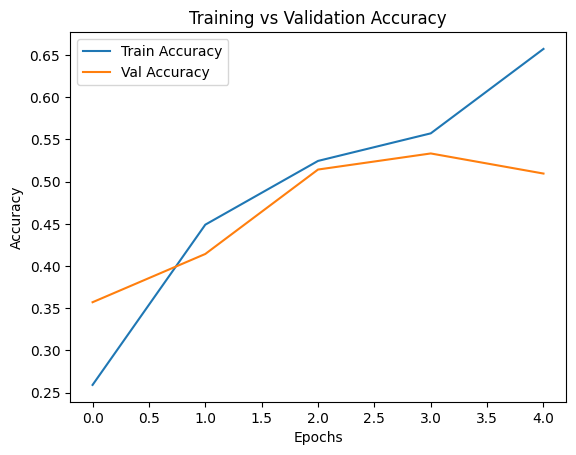

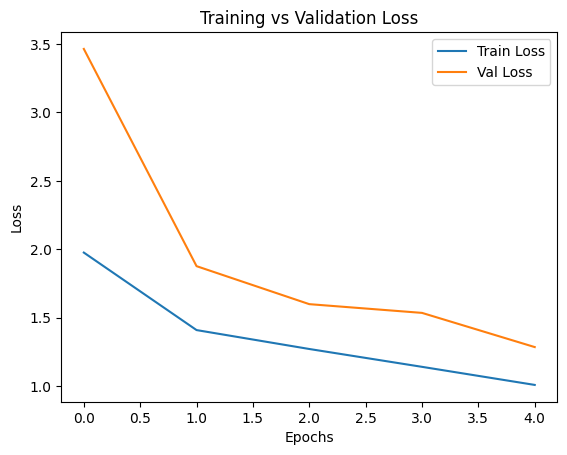

In [13]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


In [ ]:
# Path to the new image for prediction
img_path = '/content/unzipped_folder/dataset/Leonardo DiCaprio/001_08194468.jpg' # Example image path

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)

# Map the predicted class index back to the class name
class_names = ['Tom Cruise', 'Scarlett Johansson', 'Will Smith', 'Leonardo DiCaprio', 'Johnny Depp', 'Megan Fox'] # Ensure this matches your dataset classes
predicted_class_name = class_names[predicted_class_index[0]]

# Output the prediction result
print(f"Predicted class: {predicted_class_name}")

In [16]:
# Unfreeze the last few layers of the VGG16 model for fine-tuning
for layer in base_model.layers[-4:]:  # Unfreeze the last 4 layers, adjust as needed
    layer.trainable = True

# Re-compile the model after unfreezing
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_finetune = model.fit(X_train, y_train, epochs=5, batch_size=8, validation_data=(X_test, y_test))

# Save the fine-tuned model
model.save('/content/vgg16_finetuned_model.h5')


Epoch 1/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 243ms/step - accuracy: 0.5843 - loss: 1.0792 - val_accuracy: 0.6524 - val_loss: 0.9692
Epoch 2/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - accuracy: 0.6207 - loss: 1.0513 - val_accuracy: 0.7143 - val_loss: 0.9370
Epoch 3/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.6357 - loss: 0.9849 - val_accuracy: 0.7190 - val_loss: 0.9345
Epoch 4/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.6723 - loss: 0.9226 - val_accuracy: 0.7571 - val_loss: 0.8945
Epoch 5/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.6615 - loss: 0.9736 - val_accuracy: 0.7429 - val_loss: 0.8851


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input

import numpy as np

# Load the fine-tuned model
model_finetune = load_model('/content/vgg16_finetuned_model.h5')

# Path to the new image for prediction
img_path = '/content/unzipped_folder/dataset/Leonardo DiCaprio/001_08194468.jpg'
# img_path = '/content/unzipped_folder/dataset/Leonardo DiCaprio/teste1.jpg'

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))  # Resize the image to 224x224
img_array = image.img_to_array(img)  # Convert the image to a numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add an extra batch dimension (for model input)
img_array = preprocess_input(img_array)  # Preprocess the image as done during training

# Make prediction
predictions = model_finetune.predict(img_array)  # Predict the class probabilities using the fine-tuned model
predicted_class = np.argmax(predictions, axis=1)  # Get the index of the highest probability
print(f"Predicted class: {predicted_class}")

# Map the predicted class index back to the class name
class_names = ['Johnny Depp', 'Leonardo DiCaprio', 'Megan Fox', 'Scarlett Johansson', 'Tom Cruise', 'Will Smith']
predicted_class_name = class_names[predicted_class[0]]

# Output the prediction result
print(f"Predicted class: {predicted_class_name}")